In [1]:
import os
import random
import warnings
import numpy as np
import pandas as pd
from scipy import stats
from tqdm.notebook import tqdm
from itertools import product
from typing import List, Union, Any
from matplotlib import pyplot as plt
from pmdarima.arima.utils import ndiffs


from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.sm_exceptions import InterpolationWarning,ConvergenceWarning


from sklearn import set_config
from sklearn.metrics import root_mean_squared_error as rmse


set_config(
    display='diagram',
    transform_output="pandas"
)

warnings.simplefilter('ignore', InterpolationWarning)
warnings.simplefilter('ignore', ConvergenceWarning)

In [2]:
# load data
train_df = pd.read_parquet('./data/train.parquet')
train_df.index = pd.DatetimeIndex(train_df.index).to_period('h')

test_df = pd.read_parquet('./data/test.parquet')
test_df.index = pd.DatetimeIndex(test_df.index).to_period('h')

val_df = pd.read_parquet('./data/val.parquet')
val_df.index = pd.DatetimeIndex(val_df.index).to_period('h')

print(train_df.shape, val_df.shape, test_df.shape)

(24210, 9) (3459, 9) (6918, 9)


## General approach for working with a time series is to:

1. Plotting the series; notice trends and seasonality (we have done this in `data_preparation.ipynb`).
2. Detrend the time series by removing the seasonality and drift.
3. Fit a baseline model and calculate the residual.
4. Diagnose the residual.

## SARIMAX

SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous variables) is an advanced statistical model used for forecasting time series data that incorporates both seasonal and non-seasonal components, as well as external or exogenous variables that could influence the time series. It extends the ARIMA model by adding seasonality (SARIMA) and the ability to model the impact of independent external variables, making it highly versatile and powerful for handling complex forecasting scenarios. SARIMAX can be decomposed into:

* S: Seasonal

* AR: Autoregressive (p)

* I: Integrated (d)

* MA: Moving Average (q)

* X: Exogeneous variables

### Stationarity test

Stationarity means that the statistical properties of a time series i.e. mean, variance and covariance do not change over time. Many statistical models require the series to be stationary to make effective and precise predictions. The target variable must be stationary in this case. There are two tests commonly used in practice:

1. Augmented Dickey Fuller (“ADF”) test.
2. Kwiatkowski-Phillips-Schmidt-Shin (“KPSS”) test.

### ADF Test

ADF test is used to determine the presence of unit root in the series, and hence helps in understanding if the series is stationary or not. The null and alternate hypothesis of this test are:

$H_0$: the series has a unit root

$H_1$: the series has no unit root

If we fail to reject the null hypothesis, this test may provide evidence that the series is non-stationary. 


### KPSS Test

KPSS is another test for checking the stationarity of a time series. The null and alternate hypothesis for the KPSS test are opposite that of the ADF test.

$H_0$: the process is trend stationary

$H_1$: the series has a unit root (series is not stationary)


### Verdict

It is always better to apply both the tests, so that it can be ensured that the series is truly stationary. If the two tests contradict (they arrive at a different conclusion), we have two cases: 

* **Case I**: KPSS indicates non-stationarity and ADF indicates stationarity - The series is difference stationary. Differencing is to be used to make series stationary. The differenced series is checked for stationarity. 

* **Case II**: If ADF indicates non-stationarity and KPSS indicates stationarity, the series is trend stationary. The series must be detrended (via differencing or model fitting) to make it stationary.

* ADF test

In [3]:
full_train=pd.concat([train_df, val_df])

target=full_train.Global_active_power

ad_fuller_result = adfuller(target)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

print(f"{ad_fuller_result[1]} < 0.05 ? {ad_fuller_result[1] < 0.05}")
print("Stationary? ", ad_fuller_result[1] < 0.05)

ADF Statistic: -12.666951970848114
p-value: 1.2687177744246762e-23
1.2687177744246762e-23 < 0.05 ? True
Stationary?  True


* kpss test

In [4]:
kpss_result = kpss(target)

print(f'KPSS Statistic: {kpss_result[0]}')
print(f'p-value: {kpss_result[1]}')

print(f"{kpss_result[1]} < 0.05 ? {kpss_result[1] < 0.05}")
print("Stationary? ", kpss_result[1] > 0.05)

KPSS Statistic: 1.001301204978454
p-value: 0.01
0.01 < 0.05 ? True
Stationary?  False


Our tests arrive at different conclusions. In this case, ADF indicates stationarity and KPSS indicates non-stationarity. We need to difference to make our series stationary.

* How many number of differences is required?

In [5]:
n_kpss = ndiffs(target, test='kpss')
print(f'Number of differencing required: {n_kpss}')

Number of differencing required: 1


We only need on differencing to make our series stationary. Hence, no seasonal differencing is required.

In [6]:
## apply 1st-order differencing
target_diff = np.diff(target, n=1)

# Test for stationarity

# ADF Test

ad_fuller_result = adfuller(target_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

print(f"{ad_fuller_result[1]} < 0.05 ? {ad_fuller_result[1] < 0.05}")


# KPSS Test

kpss_result = kpss(target_diff)

print(f'\nKPSS Statistic: {kpss_result[0]}')
print(f'p-value: {kpss_result[1]}')

print(f"{kpss_result[1]} < 0.05 ? {kpss_result[1] < 0.05}")

ADF Statistic: -37.97005525323006
p-value: 0.0
0.0 < 0.05 ? True

KPSS Statistic: 0.013676524685657172
p-value: 0.1
0.1 < 0.05 ? False


Both tests now agree. Let's investigate the ACF and PACF plots for hints on the the appropriate lags.

## Plotting ACF and PACF functions


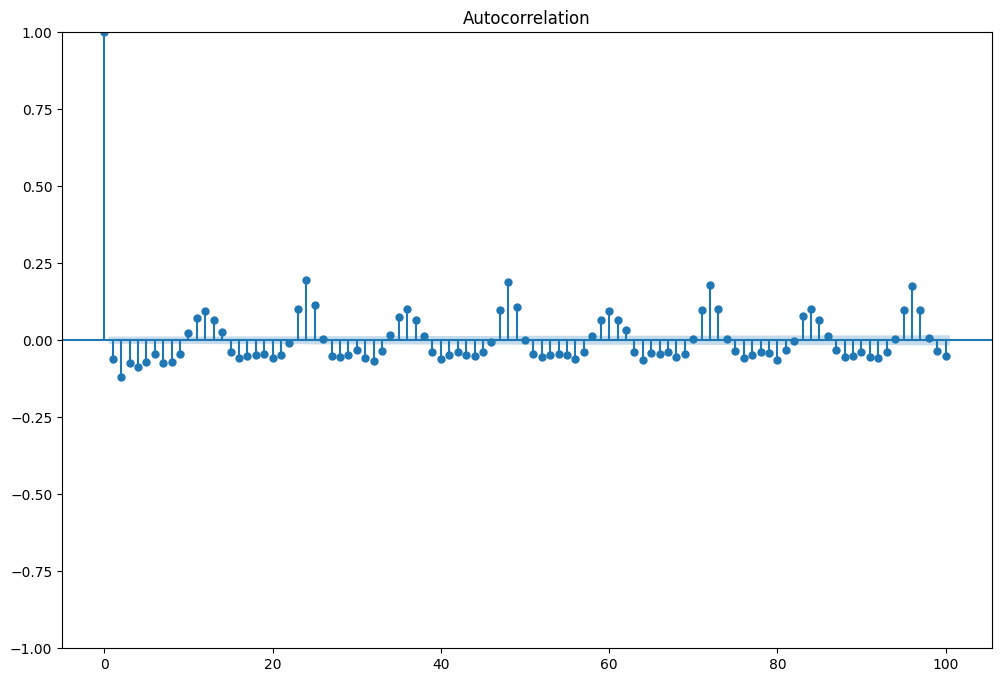

In [7]:
fig, ax = plt.subplots(figsize=(12, 8))
plot_acf(target_diff, lags=100, ax=ax)
plt.show()

Our ACF is sinusoidal. When we see a sinusoidal pattern in the ACF plot of a stationary process, this is a hint that an autoregressive process is at play, and we must use an AR(p) model to produce our forecast. However, we will have to plot the partial autocorrelation function and see at which lag the coefficients suddenly become non-significant. This lag will be our `p` in AR(p). We also see clear peaks at lags 24, 48, 72, etc, and lags 12, 24, 34, etc. This also confirms our seasonality claims. 

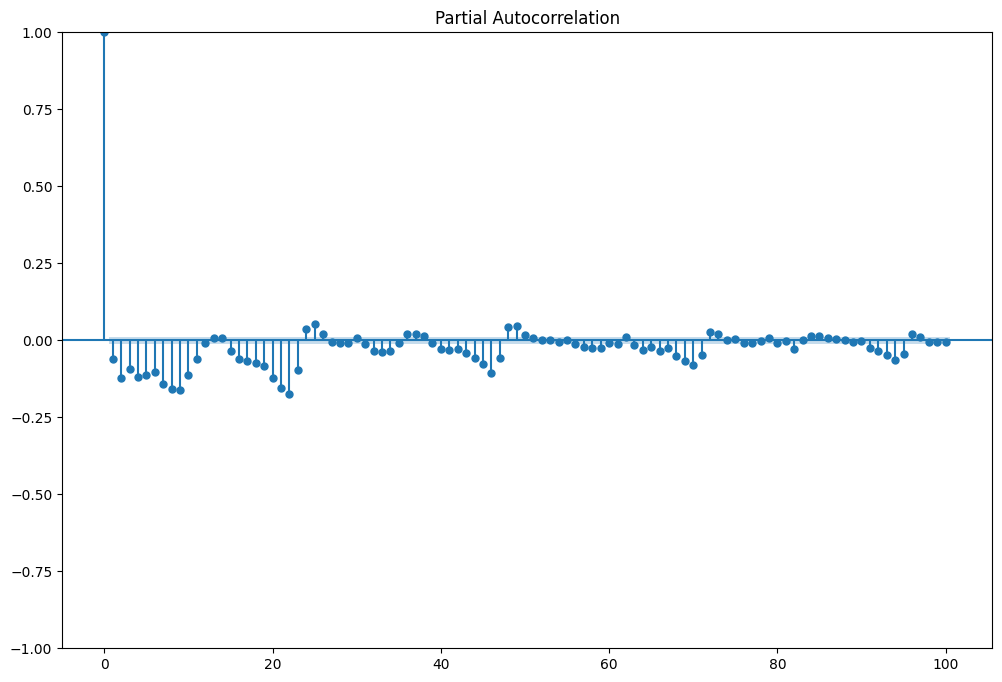

In [8]:
fig, ax = plt.subplots(figsize=(12, 8))
plot_pacf(target_diff, lags=100, ax=ax)
plt.show()

The PACF plot is also sinusoidal. This indicates no order for the MA(q) or AR(p) process that can be inferred. We are probably in the presence of an SARMA process.

We will list different possible values of p, Q, q and Q (positive integers). With a list of possible values, we can fit every unique combination of $SARIMA(p,d,q)(P,D,Q)_m$  to our data. Once that’s done, we can compute the Akaike Information Criterion (AIC), Root Mean Squared Error (RMSE), Coefficient of Determination ($R^2$), Mean Absolute Error (MAE), or other metrics. The model with the best metric is then selected. This is essentially hyperparameter optimization. Note that because we did not do a seasonal diffenece to make our series stationary, the D component of our SARIMA will be 0. In essense, our model is:

$$SARIMA(p,d,q)(P,D,Q)_m = SARIMA(p,1,q)(P,0,Q)_{24}$$ 

I will randomly selected 15 combinations so that the model runs for a reasonable time.


In [27]:
def sarimax_randomized_grid_search(
        train_y: pd.Series,
        train_X: pd.DataFrame,
        order_list: List[Any],
        n_iter: int = 25,
        d: int = 0,
        D: int = 0
) -> pd.DataFrame:
    """
    Perform a grid search over ARIMAX hyperparameters on the provided training data.
    
    Parameters
    ----------
    train_y : pd.Series
        The training data (response) for the ARIMAX model.
    train_X : pd.DataFrame
        The training data (predictors) for the ARIMAX model.
    order_list : List[Any]
        The range of 'p', 'd', 'q', and seasonal parameters to search over.
    n_iter : int
        The number of parameter combinations to try.
    d : int
        The number of non-seasonal differences to take.
    D : int
        The number of seasonal differences to take.

    Returns
    -------
    pd.DataFrame
        A DataFrame containing 'p', 'd', 'q', and corresponding metric (AIC) for each combination of hyperparameters.
    """

    random.seed(42)
    sampled_order_list = random.sample(order_list, min(len(order_list), n_iter))

    results = []

    for order in tqdm(sampled_order_list):
        try:
            model = SARIMAX(
                endog=train_y, 
                exog=train_X,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], 24),
                trend='c'
            )
            model_fit = model.fit(disp=False)

            aic = model_fit.aic
            results.append({
                'order(p, 1, q)(P, 0, Q, 24)': order,
                'AIC': aic
            })

        except Exception as e:
            print(f"Error with order {order}: {e}")
            continue

    results_df = pd.DataFrame(results)

    return results_df


In [11]:
p = range(0, 3, 1)
q = range(0, 3, 1)
P = range(0, 3, 1)
Q = range(0, 3, 1)

parameters = product(p, q, P, Q)
parameters_list = list(parameters)


train_exo, train_endo=full_train.drop(['Global_active_power', 'day_sin', 'day_cos'], axis=1), full_train[['Global_active_power']]
test_exo, test_endo=test_df.drop(['Global_active_power', 'day_sin', 'day_cos'], axis=1), test_df[['Global_active_power']]

sarimax_results = sarimax_randomized_grid_search(
    train_y=train_endo,
    train_X=train_exo,
    order_list=parameters_list,
    n_iter=10,
    d=1,
    D=0
)

  0%|          | 0/10 [00:00<?, ?it/s]

## Model Selection

Let's select the best model using AIC.

In [12]:
sarimax_results.sort_values('AIC').head(3)

,"order(p, 1, q)(P, 0, Q, 24)",AIC
7,"(2, 1, 2, 0)",80490.807502
5,"(0, 1, 2, 2)",81878.256733
6,"(0, 1, 1, 1)",82072.136602


Best model based on AIC

$$SARIMA(2,1,2)(2,0,2)_{24}$$ 

In [13]:
## create results directory

os.makedirs('./results', exist_ok=True)

sarimax_results.sort_values('AIC').to_csv('./results/sarimax_grid_search_results.csv', index=False)

## Model Diagnostics

In [33]:
best_order = sarimax_results.sort_values('AIC').iloc[0]['order(p, 1, q)(P, 0, Q, 24)']
print("=========================================")
print(f"Best order: SARIMA({best_order[0]}, 1, {best_order[1]})({best_order[2]}, 0, {best_order[3]})_[24]")
print("=========================================\n")

final_model = SARIMAX(
    endog=train_endo, 
    exog=train_exo,
    order=(best_order[0], 1, best_order[1]),
    seasonal_order=(best_order[2], 0, best_order[3], 24),
    trend='c',
).fit(disp=False)

print(final_model.summary())

Best order: SARIMA(2, 1, 1)(2, 0, 0)_[24]

                                      SARIMAX Results                                      
Dep. Variable:                 Global_active_power   No. Observations:                27669
Model:             SARIMAX(2, 1, 1)x(2, 0, [], 24)   Log Likelihood              -40232.404
Date:                             Mon, 04 Mar 2024   AIC                          80490.808
Time:                                     08:28:58   BIC                          80597.772
Sample:                                 12-16-2006   HQIC                         80525.261
                                      - 02-11-2010                                         
Covariance Type:                               opg                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
intercept                -0.0009      0.0

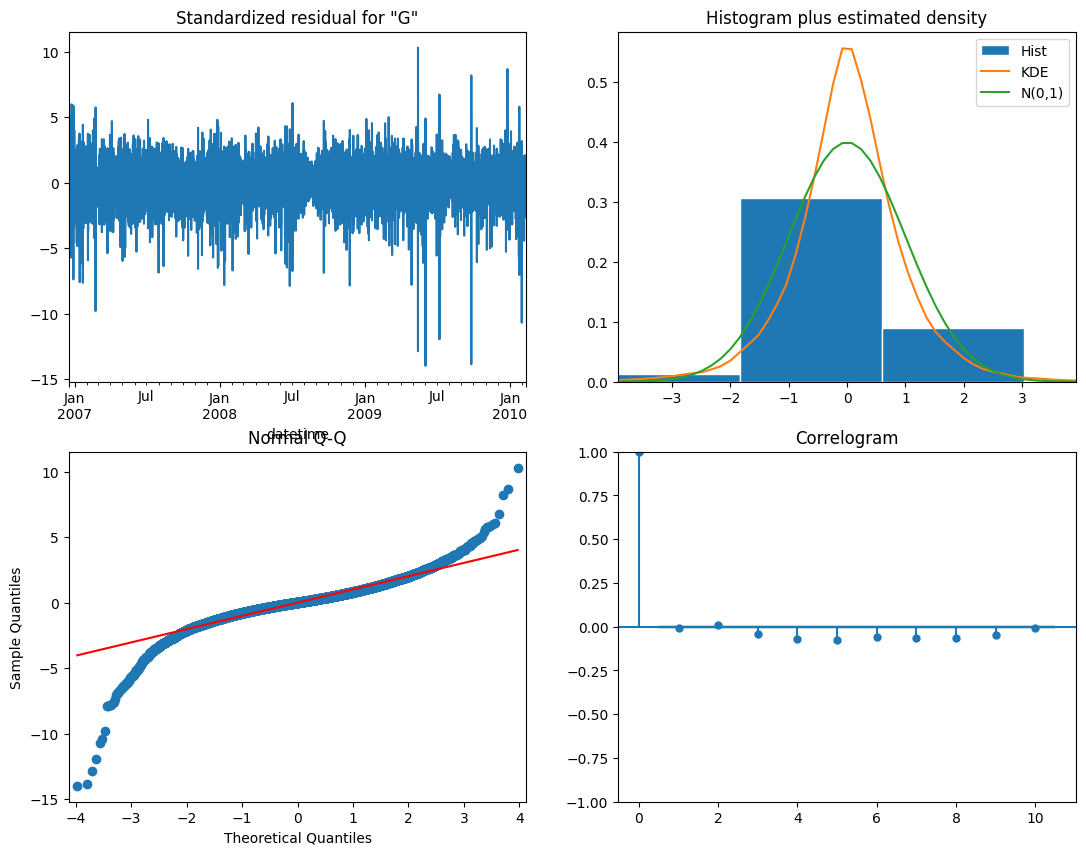

In [15]:
final_model.plot_diagnostics(figsize=(13, 10));

## Assumptions

When using a statistical model for time series analysis, some assumptions must be made about the residual. In most time series models, the residual is the difference between the observed and the predicted values.  A good forecasting model should yield residual with the following property:

1. **The residuals are independent**: the residual of a good forecasting model should not be autocorrelated. This assumption can be tested using the Ljung-Box test. The null and alternative hypothesis of the Ljung-Box test are:



In [20]:
acorr_ljungbox(final_model.resid, lags=2, return_df=True)

,lb_stat,lb_pvalue
1,2.781824,0.095340
2,4.161008,0.124867


In [21]:
# Apply Box-Cox Transformation
transformed_target, lambda_value = stats.boxcox(target)

In [22]:


# ADF Test

print("ADF Test\n========")

ad_fuller_result = adfuller(transformed_target)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

print(f"{ad_fuller_result[1]} < 0.05 ? {ad_fuller_result[1] < 0.05}")
print("Stationary? ", ad_fuller_result[1] < 0.05)


# KPSS Test

print("\nKPSS Test\n=========")

kpss_result = kpss(transformed_target)

print(f'KPSS Statistic: {kpss_result[0]}')
print(f'p-value: {kpss_result[1]}')

print(f"{kpss_result[1]} > 0.05 ? {kpss_result[1] > 0.05}")
print("Stationary? ", kpss_result[1] > 0.05)

ADF Test
ADF Statistic: -10.393662850065734
p-value: 1.990803587079955e-18
1.990803587079955e-18 < 0.05 ? True
Stationary?  True

KPSS Test
KPSS Statistic: 1.0350243133938544
p-value: 0.01
0.01 > 0.05 ? False
Stationary?  False


In [23]:
from scipy.signal import periodogram

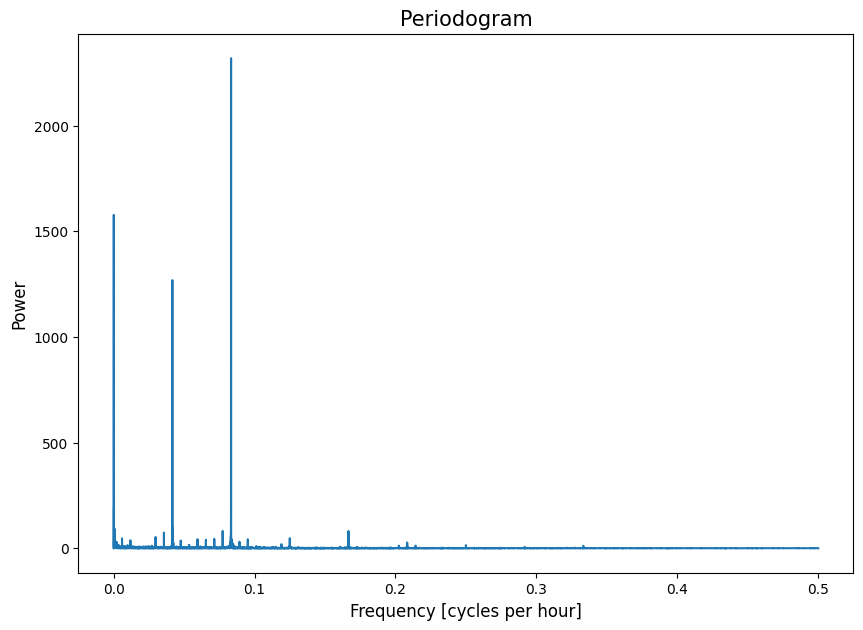

In [24]:
# Sampling frequency: 1 hour (the time unit is hours)
fs = 1

# Compute periodogram
frequencies, power = periodogram(transformed_target, fs)

# Plot the periodogram
plt.figure(figsize=(10,7))
plt.plot(frequencies, power)
plt.xlabel('Frequency [cycles per hour]', fontsize=12)
plt.ylabel('Power', fontsize=12)
plt.title('Periodogram', fontsize=15)
plt.show()

In [25]:
# identifying the top three dominant frequencies

top_3_freqs = frequencies[np.argsort(power)[-3:]][::-1]

# Compute the corresponding periods
top_3_periods = 1 / top_3_freqs

print("==============\nTop 3 periods:\n==============")

for i, period in enumerate(top_3_periods):
    print(f"Period {i+1}: {period:.2f} hours or {period/24:.2f} days")

Top 3 periods:
Period 1: 12.00 hours or 0.50 days
Period 2: 9223.00 hours or 384.29 days
Period 3: 24.00 hours or 1.00 days


In [26]:
## apply 1st-order differencing
target_diff = np.diff(transformed_target, n=1)

# Test for stationarity

# ADF Test

ad_fuller_result = adfuller(target_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

print(f"{ad_fuller_result[1]} < 0.05 ? {ad_fuller_result[1] < 0.05}")


# KPSS Test

kpss_result = kpss(target_diff)

print(f'KPSS Statistic: {kpss_result[0]}')
print(f'p-value: {kpss_result[1]}')

print(f"{kpss_result[1]} < 0.05 ? {kpss_result[1] < 0.05}")

ADF Statistic: -37.948736508736914
p-value: 0.0
0.0 < 0.05 ? True
KPSS Statistic: 0.012189301970950191
p-value: 0.1
0.1 < 0.05 ? False


In [28]:
train_exo, train_endo=full_train.drop(['Global_active_power', 'day_sin', 'day_cos'], axis=1), pd.Series(transformed_target, index=full_train.index)

sarimax_results = sarimax_randomized_grid_search(
    train_y=train_endo,
    train_X=train_exo,
    order_list=parameters_list,
    n_iter=10,
    d=1,
    D=0
)

  0%|          | 0/10 [00:00<?, ?it/s]

In [29]:
sarimax_results.sort_values('AIC').head(3)

,"order(p, 1, q)(P, 0, Q, 24)",AIC
7,"(2, 1, 2, 0)",-721.600276
5,"(0, 1, 2, 2)",311.651100
0,"(0, 1, 1, 2)",426.905278


In [30]:
best_order = sarimax_results.sort_values('AIC').iloc[0]['order(p, 1, q)(P, 0, Q, 24)']
print("=========================================")
print(f"Best order: SARIMA({best_order[0]}, 1, {best_order[1]})({best_order[2]}, 0, {best_order[3]})_[24]")
print("=========================================\n")

final_model = SARIMAX(
    endog=train_endo, 
    exog=train_exo,
    order=(best_order[0], 1, best_order[1]),
    seasonal_order=(best_order[2], 0, best_order[3], 24)
).fit(disp=False)

print(final_model.summary())

Best order: SARIMA(2, 1, 1)(2, 0, 0)_[24]

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                27669
Model:             SARIMAX(2, 1, 1)x(2, 0, [], 24)   Log Likelihood                 373.800
Date:                             Sun, 03 Mar 2024   AIC                           -723.600
Time:                                     22:15:06   BIC                           -624.864
Sample:                                 12-16-2006   HQIC                          -691.797
                                      - 02-11-2010                                         
Covariance Type:                               opg                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Global_reactive_power     0.0077      0.0

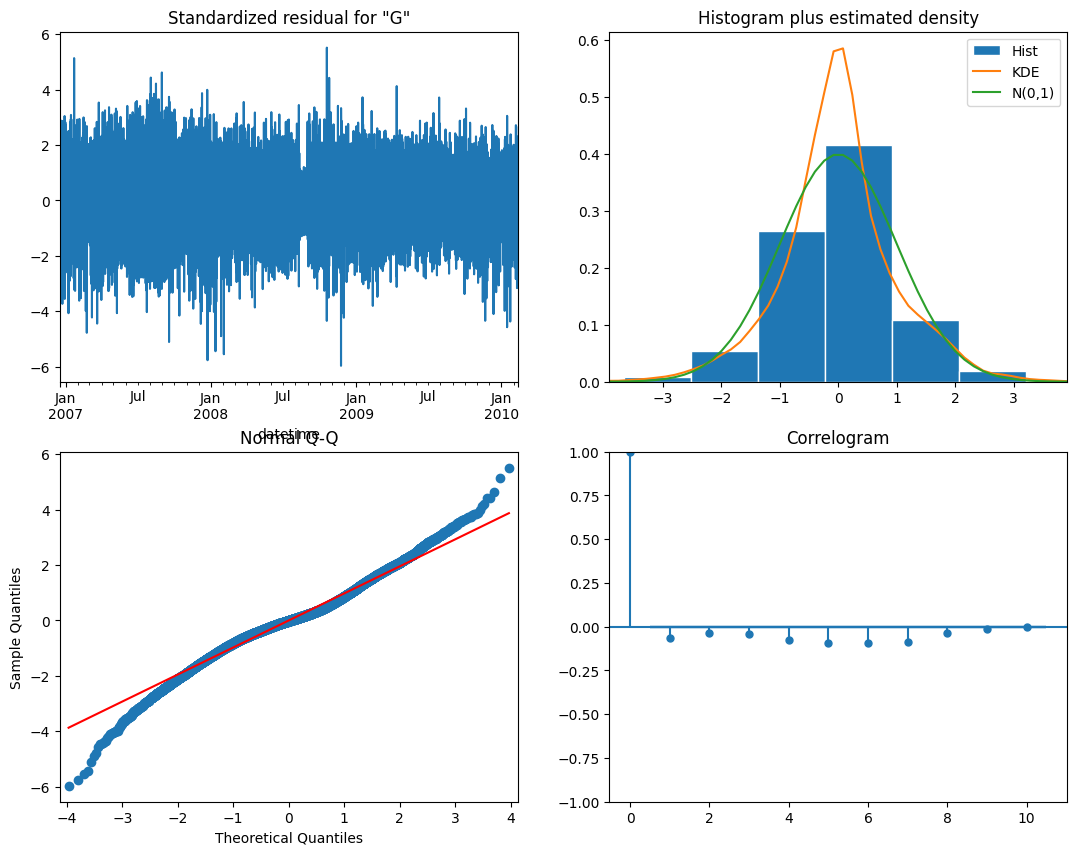

In [52]:
final_model.plot_diagnostics(figsize=(13, 10));

## Let's make some forecasting

In [49]:
final_model.resid.mean()

0.00010078345129044806

In [ ]:
## ljung-box test

ljung_box_test = acorr_ljungbox(final_model.resid, lags=24, return_df=True)

In [8]:
from scipy.special import inv_boxcox

original_data = inv_boxcox(transformed_data, lambda_value)